<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Geographic Arbitrage

_by Joe Hamman (CarbonPlan) and Grayson Badgley, January 25, 2021_


In [1]:
!pip install descartes
!pip install -e ..

Obtaining file:///home/jovyan/retro
  Running setup.py develop for carbonplan-retro


In [17]:
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd

from carbonplan import styles
from carbonplan.data import cat as core_cat
from carbonplan_retro.data import cat
from carbonplan_retro.load.fia import load_fia_state_long, to_geodataframe
from carbonplan_retro.load.arb_fortypcds import load_arb_fortypcds

styles.mpl.set_theme(style="carbonplan_light")
colors = styles.colors.light

## Input data

#### 4km Albers Equal Area Grid


In [19]:
ds = core_cat.grids.conus4k.to_dask()

display(ds)

mask = ds.mask.values.flat > 0
crs = ds.crs.attrs["crs_wkt"]

<xarray.Dataset>
Dimensions:  (x: 1209, x_b: 1210, y: 783, y_b: 784)
Coordinates:
  * x        (x) float64 -2.491e+06 -2.487e+06 ... 2.337e+06 2.341e+06
  * y        (y) float64 3.308e+06 3.304e+06 3.3e+06 ... 1.84e+05 1.8e+05
Dimensions without coordinates: x_b, y_b
Data variables:
    area     (y, x) float64 dask.array<chunksize=(196, 303), meta=np.ndarray>
    crs      int64 ...
    lat      (y, x) float64 dask.array<chunksize=(196, 303), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(196, 303), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(196, 303), meta=np.ndarray>
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(196, 303), meta=np.ndarray>
    mask     (y, x) int64 dask.array<chunksize=(196, 303), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    history:      created by jhamman, 2020-09-23 19:08:35.897424
    title:        Albers 4k CONUS Domain

#### FIA Condition Level Table


In [20]:
df_ca = load_fia_state_long("ca")
df_or = load_fia_state_long("or")
df = pd.concat([df_ca, df_or], axis=0, ignore_index=True)
df = df[(df['MEASYEAR'] > 2000) & (df['MEASYEAR'] < 2015)]
df = df[(df['OWNCD'] == 46)]

# project to Albers
df = df.to_crs(crs)

display(df.head())

,adj_ag_biomass,OWNCD,CONDID,STDAGE,MEASYEAR,SITECLCD,FORTYPCD,FLDTYPCD,ECOSUBCD,CONDPROP_UNADJ,COND_STATUS_CD,SLOPE,ASPECT,INVYR,LAT,LON,ELEV,slag_co2e_acre,postal_code,geometry
1609,56.128504,46.0,1,NaN,2006.0,7.0,924.0,924.0,M261Ep,1.000000,1,25.0,206.0,2006,36.981267,-119.264873,2900.0,41.660833,ca,POINT (-2031127.623 1798524.296)
1610,6.028056,46.0,1,0.0,2006.0,5.0,999.0,371.0,M261Ep,0.760771,1,17.0,257.0,2006,37.135219,-119.264407,5700.0,4.474266,ca,POINT (-2026906.809 1815250.619)
1611,145.917197,46.0,2,90.0,2006.0,5.0,371.0,371.0,M261Ep,0.239229,1,17.0,257.0,2006,37.135219,-119.264407,5700.0,108.305612,ca,POINT (-2026906.809 1815250.619)
1612,37.024731,46.0,1,NaN,2006.0,7.0,924.0,924.0,M261Ca,0.882075,1,44.0,132.0,2006,39.526954,-122.579499,1100.0,27.481244,ca,POINT (-2234650.746 2148522.934)
1613,61.567832,46.0,1,21.0,2006.0,4.0,941.0,202.0,263Ag,1.000000,1,60.0,84.0,2006,40.034235,-123.907400,900.0,45.698121,ca,POINT (-2326690.934 2234917.274)


#### Supersection geometries


<AxesSubplot:>

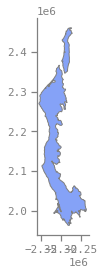

In [21]:
supersections = cat.supersections.read().set_index("SSection").to_crs(crs=crs)
section_name = 'Northern California Coast'  #"Southern Cascades"  # we'll use this for testing
supersections.loc[[section_name]].plot()

### Create the evaluation mesh


<AxesSubplot:>

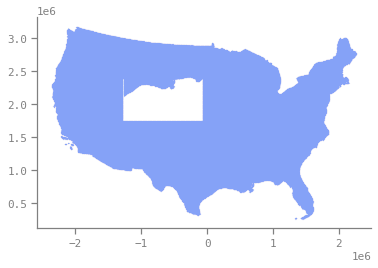

In [22]:
# create the mesh that we will sample from
points = [Point(x, y) for x, y in zip(ds.lon.values.flat[mask], ds.lat.values.flat[mask])]

mesh = geopandas.GeoDataFrame(
    data={"num": list(range(len(points)))}, crs="epsg:4326", geometry=points
)
mesh = mesh.to_crs(crs=crs)
mesh.plot(markersize=0.01)

<AxesSubplot:>

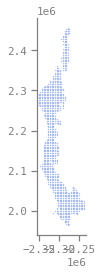

In [23]:
# show that we can subset the mesh by supersection
supersection_mesh = geopandas.clip(mesh, supersections.loc[[section_name]])
supersection_mesh.plot(markersize=0.1)

Next we want to calculate the average above ground biomass for each mesh location based on its
nearest 100 neighbors. For this example, we look at only FORTYPCD < 400. We use a `KDTree` to
quickly select the closest points.


In [24]:
# get a subset of the FIA table
subset_df = df[df["FORTYPCD"] < 400]

# create the KDTree
tree = KDTree(np.stack([subset_df.geometry.x.values, subset_df.geometry.y.values], axis=1))

# pick a sample point in the mesh
pind = 300
p = supersection_mesh.geometry.iloc[pind]
xy = (p.x, p.y)

# Find the indicies of the nearest 100 points
inds = tree.query([xy], k=100, return_distance=False)[0]

# Finally, pull out the 100 conds from the FIA table
p_plots = subset_df.iloc[inds]

<AxesSubplot:ylabel='Frequency'>

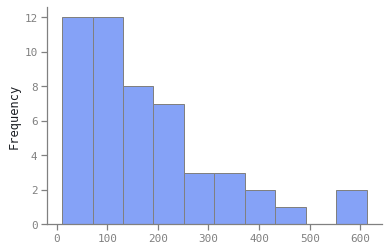

In [25]:
p_plots[p_plots['FORTYPCD'] == 201]['slag_co2e_acre'].plot.hist()

A quick visual. Belovalue_counts the full supersection mesh (grey), a single evaluation point (black),
and the selected FIA Conditions (red).


<AxesSubplot:>

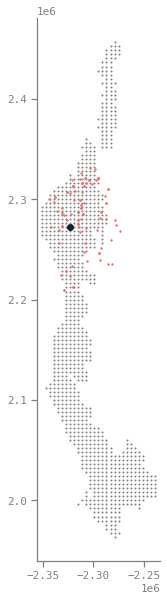

In [26]:
fig, ax = plt.subplots(figsize=(5, 10))

supersection_mesh.plot(ax=ax, c=colors["secondary"], markersize=1, label="sample mesh")
p_plots.plot(ax=ax, c=colors["red"], markersize=2, label="fia points")
supersection_mesh.iloc[[pind]].plot(ax=ax, c=colors["primary"], label="sample point")

# ax.legend()

#### The simplest arbitrage map

Now, we can calculate a simple version of the arbitrage map by calculating the mean above ground
biomass for all mesh locations by taking the average of the 100 closest FIA conditions.


In [27]:
mean_agb = []
for p in supersection_mesh.geometry:
    xy = p.x, p.y
    inds = tree.query([xy], k=100, return_distance=False)[0]
    mean_agb.append(subset_df["adj_ag_biomass"].iloc[inds].mean())
supersection_mesh["mean_agb"] = mean_agb

In [28]:
supersection_df = geopandas.clip(subset_df.reindex(), supersections.loc[[section_name]])
supersection_mesh["mean_agb_diff"] = supersection_mesh["mean_agb"] - supersection_df["adj_ag_biomass"].mean()

Now we plot the above ground biomass map.


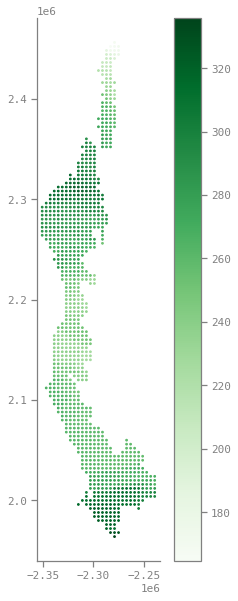

In [29]:
fig, ax = plt.subplots(figsize=(5, 10))
ax = supersection_mesh.plot("mean_agb", cmap="Greens", legend=True, ax=ax, markersize=3)

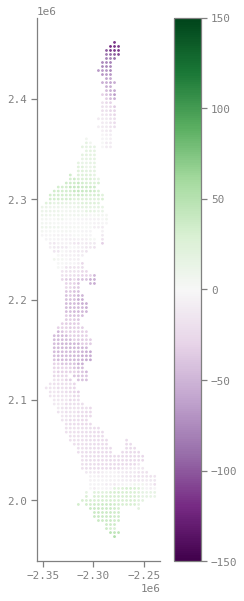

In [30]:
fig, ax = plt.subplots(figsize=(5, 10))
ax = supersection_mesh.plot("mean_agb_diff", cmap="PRGn", legend=True, ax=ax, markersize=3, vmin=-150, vmax=150)

### all together now!

The cell below is semi-complete but should illustrate how to repeate the steps above for all
supersections/assessment areas.

In [31]:
supersection_names = ['Southern Cascades', 'Northern California Coast']
assessment_areas = [297, 221]

fortype_dict = load_arb_fortypcds()

results = {}
subsets = {}

for supersection_name, aa_id in zip(supersection_names, assessment_areas):
    print(supersection_name, aa_id)

    subset_df = df[df['FORTYPCD'].isin(fortype_dict[aa_id])]

    tree = KDTree(np.stack([subset_df.geometry.x.values, subset_df.geometry.y.values], axis=1))

    supersection_mesh = geopandas.clip(mesh, supersections.loc[[supersection_name]])

    mean_agb = []
    for p in supersection_mesh.geometry:
        xy = p.x, p.y
        inds = tree.query([xy], k=100, return_distance=False)[0]
        mean_agb.append(subset_df["adj_ag_biomass"].iloc[inds].mean())
    supersection_mesh['mean_agb'] = mean_agb
        
    results[supersection_name] = supersection_mesh
    subsets[supersection_name] = subset_df

Southern Cascades 297
Northern California Coast 221


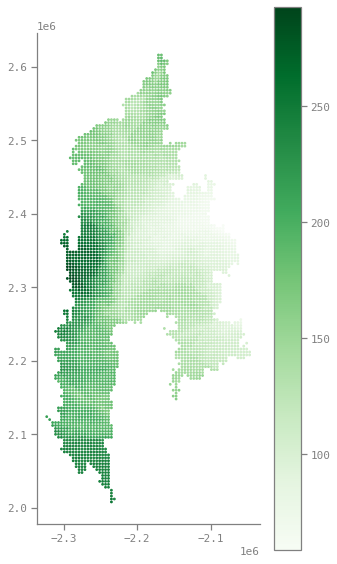

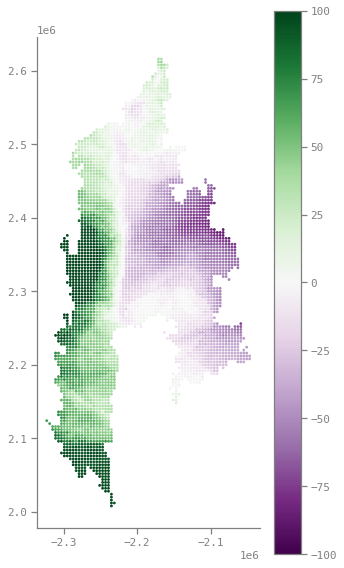

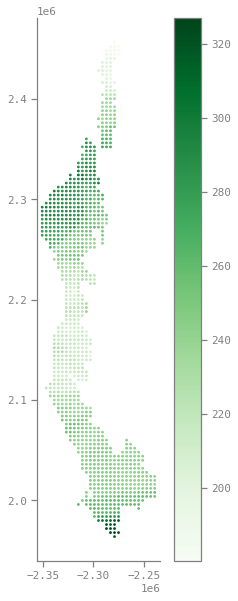

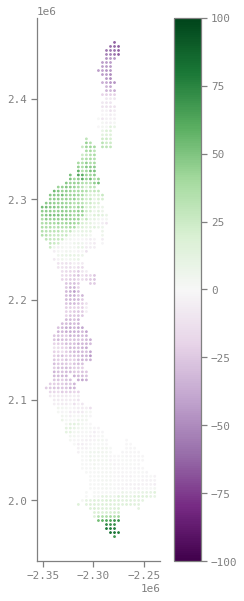

In [39]:
for supersection_name in supersection_names:
    
    supersection_mesh = results[supersection_name]
    subset_df = subsets[supersection_name]
    
    supersection_df = geopandas.clip(subset_df.reindex(), supersections.loc[[supersection_name]])
    supersection_mesh["mean_agb_diff"] = supersection_mesh["mean_agb"] - supersection_df["adj_ag_biomass"].mean()
    
    fig, ax = plt.subplots(figsize=(5, 10))
    ax = supersection_mesh.plot("mean_agb", cmap="Greens", legend=True, ax=ax, markersize=3)
    
    fig, ax = plt.subplots(figsize=(5, 10))
    ax = supersection_mesh.plot("mean_agb_diff", cmap="PRGn", legend=True, ax=ax, markersize=3, vmin=-100, vmax=100)
